In [3]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from bs4 import BeautifulSoup
from matplotlib_venn import venn2
from matplotlib_venn_wordcloud import venn2_wordcloud
import praw
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords # Import the stop word list
from sklearn.naive_bayes import MultinomialNB
from time import sleep
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

%matplotlib inline
matplotlib.style.use('fivethirtyeight')

## Data Science Problem

Data Science Problem: To differentiate posts found on the subreddits r/notTheOnion and r/TheOnion

**Introduction**:  
r/TheOnion is a subreddit that is dedicated to articles from the satirical newspaper The Onion. The Onion's articles cover current events, both real and fictional, satirizing the tone and format of traditional news organizations with stories, editorials, and man-on-the-street interviews using a traditional news website layout and an editorial voice modeled after that of the Associated Press. The publication's humor often depends on presenting mundane, everyday events as newsworthy, surreal, or alarming, such as "Rotation of Earth Throws Entire North American Continent into Darkness".

r/notTheOnion on the other hand, is dedicated to real-life news articles that are absurd, surreal or ludicrous to the point that one suspects if it is in fact satire, more specifically that published by The Onion.

**Why these two subreddits were chosen**
The posts in these subreddits are limited to links to the actual news articles, with the titles being the actual article headlines, and are similiar in form. Submissions are also chosen in r/notheonion's case to be similiar in content to r/TheOnion, making this problem more difficult.

Few, if any of the posts contain self-text, and it I think it will be an interesting and challenging project.

## Data Scraping and Cleaning

### Accessing reddit API for subreddit posts

#### Writing headers and url

In [24]:
header={'User-agent':'subdiff:v1.00'}
url='https://www.reddit.com/r/theonion/new.json'
res=requests.get(url,headers=header)


#### Passing json into list

In [25]:
url='https://www.reddit.com/r/theonion/new.json'
after=1
to=[]
url2=url
while(after):
    res=requests.get(url2,headers=header)
    to_dict = res.json()
    for entry in to_dict['data']['children']:
        to.append(entry['data']['title'])
    
    after=to_dict['data']['after']
    if after:
        url2=url+'?after='+after
        sleep(1)
    else:
        break

In [98]:
after=1
nto=[]
url='https://www.reddit.com/r/nottheonion/new.json?limit=100;'
url2=url
while(after):
    res=requests.get(url2,headers=header)
    to_dict = res.json()
    for entry in to_dict['data']['children']:
        nto.append(entry['data']['title'])
    
    after=to_dict['data']['after']
    if after:
        url2=url+'after='+after
        sleep(2)
    else:
        break

In [28]:
len(to)

998

In [29]:
len(nto)

906

#### Using PushShift.io to get more posts
I can only get 1000 posts, so I turn to pushshift.io for more entries

In [634]:
to=[]
url='https://api.pushshift.io/reddit/search/submission/?q=&subreddit=theonion&size=10000'

res=requests.get(url,headers=header)
to_dict = res.json()



**Because the largest request size is 1000, we have to iterate until N=10000**

In [653]:
N = 0
last = ''
ids = []
to=[]
url='https://api.pushshift.io/reddit/search/submission/?q=&subreddit=theonion&fields=id,created_utc,title&size=1000'

while N < 10000:
    request = requests.get('{}&before={}'.format(url,last))
    json = request.json()
    for s in json['data']:
        ids.append(s['id'])
        to.append(s['title'])
        N += 1
    last = int(s['created_utc'])

In [655]:
len(to)

10000

In [659]:
todf=pd.DataFrame(to,columns=['titles'])

**Drop Duplicate submissions**

In [711]:
todf=todf.drop_duplicates()

In [1088]:
todf.isnull().sum()

titles         0
target         0
length         0
word length    0
dtype: int64

In [712]:
todf.shape

(9197, 3)

**Repeat process for r/nottheonion**

In [656]:
N = 0
last = ''
ids = []
nto=[]
url='https://api.pushshift.io/reddit/search/submission/?q=&subreddit=nottheonion&fields=id,created_utc,title&size=1000'

while N < 10000:
    request = requests.get('{}&before={}'.format(url,last))
    json = request.json()
    for s in json['data']:
        ids.append(s['id'])
        nto.append(s['title'])
        N += 1
    last = int(s['created_utc'])

In [657]:
len(nto)

10000

In [708]:
ntodf=pd.DataFrame(nto,columns=['titles'])

In [709]:
ntodf=ntodf.drop_duplicates()

In [1089]:
ntodf.isnull().sum()

titles         0
target         0
length         0
word length    0
dtype: int64

In [710]:
ntodf.shape

(7898, 1)

#### Alternate method using Python Reddit API Wrapper**(from which we found the self-text is empty except for one instance, and so we didn't collect it)

In [626]:
reddit = praw.Reddit(client_id='5PSPLnAopcS4Gg',
                     client_secret='aXYcVIqwgZZueLAMqcVc6kORImY',
                     user_agent='user_agent')
    
nto=[submission for submission in reddit.subreddit('nottheonion').top(limit=2000)]
to=[submission for submission in reddit.subreddit('theonion').top(limit=2000)]

In [627]:
#len(nto)

965

In [628]:
#len(to)

999

In [ ]:
#ntodf=pd.DataFrame({'titles':[sub.title for sub in nto],'selftext':[sub.selftext for sub in nto]})
#ntodf['selftext'].value_counts()

In [ ]:
#todf=pd.DataFrame({'titles':[sub.title for sub in to],'selftext':[sub.selftext for sub in to]})
#todf['selftext'].value_counts()

#### Add target column and concat the two dataframes

In [713]:
ntodf['target']=np.zeros(shape=ntodf['titles'].shape)
todf['target']=np.ones(shape=todf['titles'].shape)

In [714]:
df=pd.concat([ntodf[['titles','target']],todf[['titles','target']]])
df.reset_index(drop=True,inplace=True)

In [715]:
df.head()

,titles,target
0,Founders Brewing manager claims he didn’t know...,0.0
1,Lid on 1947-49 Kashmir files? Archives reveal ...,0.0
2,"Lions and rhinos are farm animals, says South ...",0.0
3,"‘Humane, professional’ Hong Kong police force ...",0.0
4,Kashmir Politicians Refuse to Sign Bond Bannin...,0.0


In [716]:
df.tail()

,titles,target
17090,How Trump Writes His Tweets,1.0
17091,Trump Boys Sadly Release Pet Alligator Into Li...,1.0
17092,A glimpse into the Female world of Web design:...,1.0
17093,They Said What?!: Find Out What Soledad O’Brie...,1.0
17094,USD 1000 Paypal Account only0.08 Bitcoin (or $...,1.0


In [717]:
df.to_csv('ntoto.csv')

In [4]:
df=pd.read_csv('ntoto.csv')

In [5]:
ntodf=pd.DataFrame(df[df['target']==0])
todf=pd.DataFrame(df[df['target']==1])


## EDA

#### Word length Histogram

In [5]:
ntodf['sentence length']=ntodf['titles'].apply(lambda x: len(x.split(' ')))
todf['sentence length']=todf['titles'].apply(lambda x: len(x.split(' ')))
df['sentence length']=df['titles'].apply(lambda x: len(x.split(' ')))

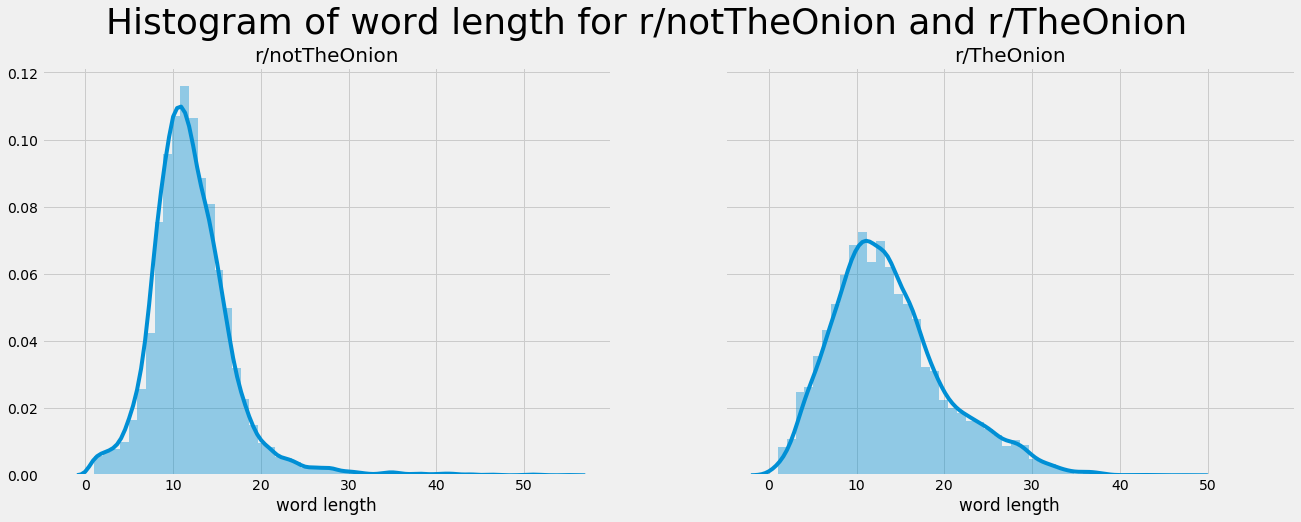

In [854]:
ncols=2
fig,ax=plt.subplots(ncols=ncols,figsize=(ncols*10,7),sharex=True,sharey=True)

sns.distplot(ntodf['sentence length'],bins=55,ax=ax[0])

sns.distplot(todf['sentence length'],bins=45,ax=ax[1])
ax[0].set_title('r/notTheOnion',fontsize=20)
ax[1].set_title('r/TheOnion',fontsize=20)
fig.suptitle('Histogram of sentence length for r/notTheOnion and r/TheOnion',fontsize=36,y=1)

plt.show()




<Figure size 720x360 with 0 Axes>

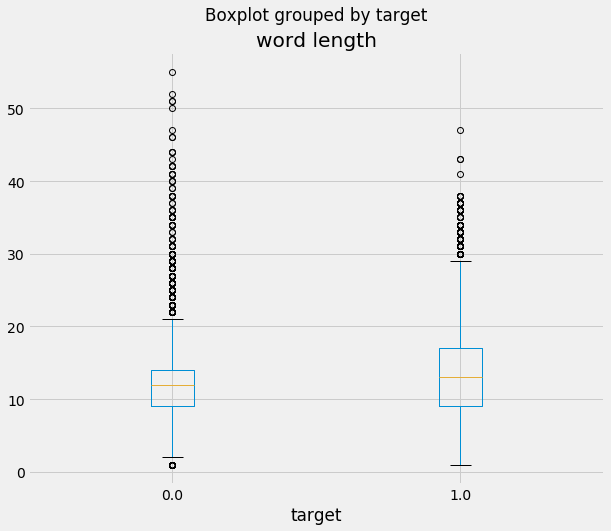

In [862]:
plt.figure(figsize=(10,5))
df.boxplot('sentence length',by='target',figsize=(10,8))

**Comments on the sentence length distributions**   
The titles length of the two subreddits are normally distributed,have similiar medians, but interestingly rather different variances. The variance of r/theonion titles is larger and is more widely distributed despite being generally balanced classes.

#### Wordcloud Visualization

In [995]:
onioncloud=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(todf['titles'].sum())
notonioncloud=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(ntodf['titles'].sum())




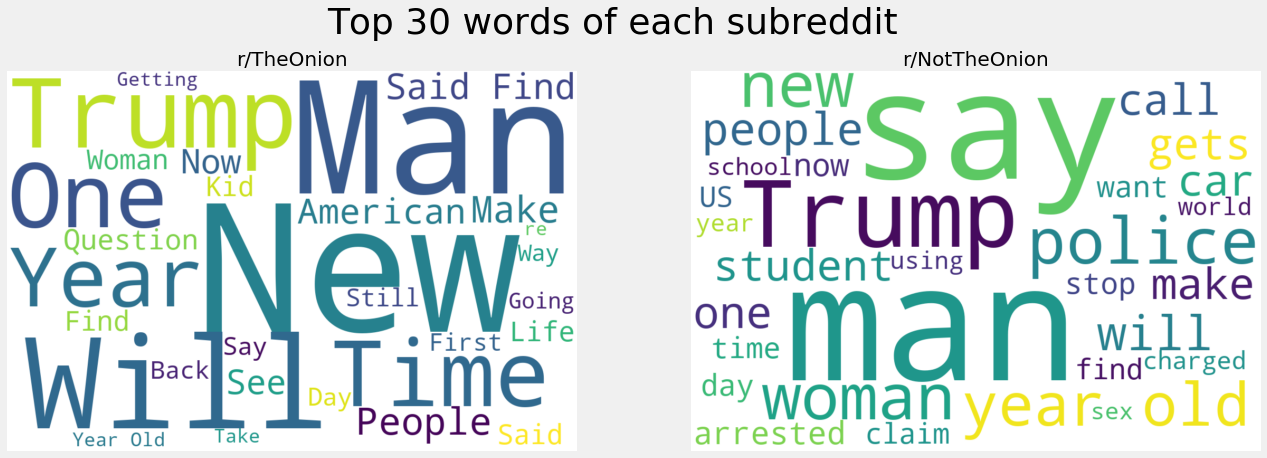

In [996]:
ncols=2
fig,ax=plt.subplots(ncols=ncols,figsize=(ncols*10,7))
ax[0].axis("off")
ax[1].axis("off")
ax[0].imshow(onioncloud, interpolation='bilinear')
ax[0].set_title('r/TheOnion',fontsize=20)
ax[1].imshow(notonioncloud, interpolation='bilinear')
ax[1].set_title('r/NotTheOnion',fontsize=20)
fig.suptitle('Top 50 words of each subreddit',fontsize=36,)

plt.show()

In [998]:
compdf=pd.DataFrame(list(onioncloud.words_.keys()),columns=['Top30Onion'])

In [999]:
compdf['Frequency1']=list(onioncloud.words_.values())
compdf['Top30notOnion']=list(notonioncloud.words_.keys())
compdf['Frequency2']=list(notonioncloud.words_.values())
compdf['Top30Onion']=compdf['Top30Onion'].apply(lambda x: x.lower())
compdf['Top30notOnion']=compdf['Top30notOnion'].apply(lambda x: x.lower())

In [1000]:
set1={word for word in compdf['Top30Onion'].values}
set2={word for word in compdf['Top30notOnion'].values}

sets=[]
sets.append(set1)
sets.append(set2)

In [973]:
cvec=CountVectorizer(stop_words=None)

In [974]:
freq_df=cvec.fit_transform(df['titles'])

In [975]:
words=cvec.get_feature_names()

In [1001]:
freq_col=pd.DataFrame(pd.DataFrame(freq_df.todense()).sum())
freq_col['words']=words
freq_col.columns=['Count','Words']
freq_col['Relative Frequency']=freq_col['Count']/freq_col['Count'].max()
freq_col.sort_values('Count',ascending=False).head(10)

,Count,Words,Relative Frequency
19272,7024,to,1.000000
13174,4474,of,0.636959
19055,4410,the,0.627847
9592,3564,in,0.507403
7581,2736,for,0.389522
1070,1967,and,0.280040
13256,1935,on,0.275484
20986,1615,with,0.229926
767,1428,after,0.203303
10055,1392,is,0.198178


In [1003]:
freqdict={}
for key in list(set1.union(set2)):
    flag=0
    try: freqdict[key]=freq_col[freq_col['Words']==key]['Relative Frequency'].values[0]
    except: flag=1
    if flag:
        set1.discard(key)
        set2.discard(key)

#### We use a Venn Diagram of the top 30 occurring words of each dataset to see which words appear in each dataset most, and which ones appear in both

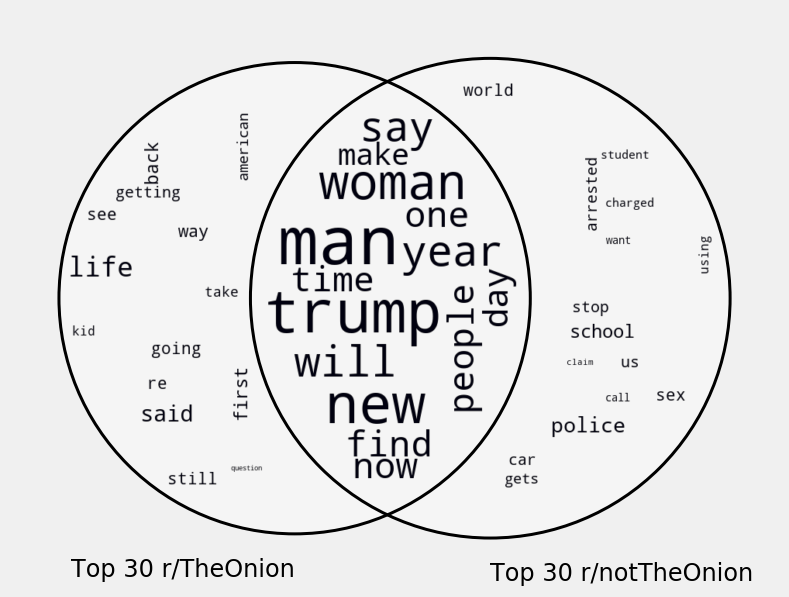

In [1004]:
plt.figure(figsize=(15,10))
venn=venn2_wordcloud([set1,set2],set_labels=['Top 30 r/TheOnion','Top 30 r/notTheOnion'],
                     ax=plt.gca(),word_to_frequency=freqdict)

**In this Venn diagram, the size of the word represents how often it appears.**

The words that appear in both subreddit, while appearing frequently, are **non-discriminating** features, and may not help very much in identifying the different subreddits.

As expected, pronouns/nouns like **"man,woman,people"** appear the most and verbs like **"make,find"** are also common to both subreddits.

The word that obviously stands out is **"Trump"** in comparison to the other less specific words and I wonder if this would be the case if we ran the post search on posts before his presidential campaign.

## Estimator selection and comparison

### Train Test Split

In [726]:
X=df['titles']
y=df['target']
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=23)

**1. Count Vectorize the corpus so we know the number of words we are working with to provide context for the pipeline parameter range selection**  
**2. Attempt no max_feature logreg**

In [727]:
cvec=CountVectorizer(stop_words='english')

In [728]:
X_train_cvec=cvec.fit_transform(X_train)

In [729]:
pd.DataFrame(X_train_cvec.todense(),columns=cvec.get_feature_names()).shape

(12821, 18496)

In [730]:
X_test_cvec=cvec.transform(X_test)

In [809]:
logreg=LogisticRegression()

In [810]:
logreg.fit(X_train_cvec,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [811]:
logreg.score(X_train_cvec,y_train)

0.9703611262772015

In [812]:
logreg.score(X_test_cvec,y_test)

0.829433785680861

In [735]:
X_train_cvec.shape

(12821, 18496)

In [ ]:
#### Defining Custom Stop Words to make the problem non-trivial

**There are 18496 features**

### Preparation of dataframes...

#### Lemma and Stem: Tokenize and strip punctuation, then lemmatize/stem

In [7]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
lemmer=WordNetLemmatizer()
stemmer=PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')
dftoken=pd.DataFrame(df['titles'].apply(lambda x: tokenizer.tokenize(x.lower())))

In [761]:
dftoken['titles']

0        [founders, brewing, manager, claims, he, didn,...
1        [lid, on, 1947, 49, kashmir, files, archives, ...
2        [lions, and, rhinos, are, farm, animals, says,...
3        [humane, professional, hong, kong, police, for...
4        [kashmir, politicians, refuse, to, sign, bond,...
5        [chinese, hitmen, jailed, over, repeatedly, ou...
6        [man, in, china, pays, hitman, s, 385, 000, to...
7        [vegan, struggles, to, get, over, trauma, of, ...
8        [kmart, pulls, offensive, children, s, bride, ...
9        [real, ham, on, pizza, leaves, aussie, vegan, ...
10       [on, j, amp, k, indian, journalist, s, face, o...
11       [the, us, nuclear, forces, dr, strangelove, er...
12       [pak, singer, poses, with, suicide, vest, to, ...
13       [u, s, air, force, retires, its, vintage, nucl...
14       [we, don, t, want, to, con, anyone, inventor, ...
15       [woman, loses, husband, lover, in, murder, plo...
16       [amit, shah, savarkar, and, the, battle, for, .

In [762]:
dflemma=pd.DataFrame(dftoken['titles'].apply(lambda x: ' '.join([lemmer.lemmatize(word) for word in x])))
dflemma['target']=df['target']
dfstem=pd.DataFrame(dftoken['titles'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x])))
dfstem['target']=df['target']

#### Lemma2 and Stem2 Lemmatize and treat the punctuation as words 

In [8]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+|[\'",\/+.-]')
dftoken2=pd.DataFrame(df['titles'].apply(lambda x: tokenizer.tokenize(x)))

In [8]:
dftoken2

,titles
0,"[Founders, Brewing, manager, claims, he, didn,..."
1,"[Lid, on, 1947, -, 49, Kashmir, files, Archive..."
2,"[Lions, and, rhinos, are, farm, animals, ,, sa..."
3,"[Humane, ,, professional, Hong, Kong, police, ..."
4,"[Kashmir, Politicians, Refuse, to, Sign, Bond,..."
5,"[Chinese, Hitmen, Jailed, Over, Repeatedly, Ou..."
6,"[Man, in, China, pays, hitman, S, 385, ,, 000,..."
7,"[Vegan, struggles, to, get, over, trauma, of, ..."
8,"[Kmart, pulls, ', offensive, ', children, ', s..."
9,"[Real, ham, on, pizza, leaves, Aussie, vegan, ..."


In [9]:
dflemma2=pd.DataFrame(dftoken2['titles'].apply(lambda x: ' '.join([lemmer.lemmatize(word.lower()) for word in x])))
dflemma2['target']=df['target']
dfstem2=pd.DataFrame(dftoken2['titles'].apply(lambda x: ' '.join([stemmer.stem(word.lower()) for word in x])))
dfstem2['target']=df['target']

In [10]:
dfstem2

,titles,target
0,founder brew manag claim he didn t know black ...,0.0
1,lid on 1947 - 49 kashmir file archiv reveal ne...,0.0
2,"lion and rhino are farm anim , say south africa",0.0
3,"human , profession hong kong polic forc to be ...",0.0
4,kashmir politician refus to sign bond ban them...,0.0
5,chines hitmen jail over repeatedli outsourc mu...,0.0
6,"man in china pay hitman s 385 , 000 to kill ri...",0.0
7,vegan struggl to get over trauma of eat domino...,0.0
8,kmart pull ' offens ' children ' s bride costu...,0.0
9,real ham on pizza leav aussi vegan feel ' betr...,0.0


### Hyper-Parameter Search

#### Summary of initial search-region

A summary of what the hyper-parameter search region:
1. 5 Different methods of modifiying the data have been used for the datasets tested:
    a. Leave the data as is and tokenize  
    b. Split by white space and punctuation then stem/lemmatize all words, dont keep punctuation  
    c. Split by white space and punctuation, stem/lemmatize only lower case words and keep punctuation
      
2. 2 different Vectorizers were tested:  
    a. Term Frequency–Inverse Document Frequency Vectorizer 
    b. Count Vectorizer
  
3. 2 different classifiers were tested(KNN is unsuitable to the sparse matrix):  
    a. Logistic Regression  
    b. Multinomial Naive Bayes  
    
4. I later added in customstop as my custom stopwords, but I had previously found that no stopwords performed better across the board than with english stopwords

In [6]:
customstop=['onion','nottheonion']

#### Function Definition

In [768]:
def SupraPipeline(Dataframes,Vectorizerlist,ClassifierList,Dfnames,pipe_params,methodgridname):
    Methodgrid=[]
    metnum=len(Dataframes)*len(Vectorizerlist)*len(Classifierlist)
    n=0
    for index,df in enumerate(Dataframes):
        X=Dataframes[index]['titles']
        y=Dataframes[index]['target']
        X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=23)

        for Vectorizer in Vectorizerlist:
            for Classifier in ClassifierList:
                n+=1
                print(f'{n} of {metnum} of methods attempting')
                method={}
                pipe = Pipeline([
                    ('vec', Vectorizer ),
                    ('class', Classifier)
                ])

                gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5,verbose=1,n_jobs=-1)
                gs.fit(X_train, y_train)
                method=(gs.best_params_)
                method['Cross_Val_Score']=(gs.best_score_)
                method['Test_Score']=gs.score(X_test,y_test)
                method['Vectorizer']=str(Vectorizer).split('(')[0]
                method['Data']=str(Dfnames[index])
                method['Classifier']=str(Classifier).split('(')[0]
                Methodgrid.append(method)
                
    Methodgrid=pd.DataFrame(Methodgrid)
    Methodgrid.to_csv(methodgridname,index=False)
    return Methodgrid

#### Widesearch across stated parameters

In [1261]:
df.to_csv()
Vectorizerlist=[TfidfVectorizer(),CountVectorizer()]
Dataframes=[df,dflemma,dfstem,dflemma2,dfstem2]
Dfnames=['df','dflemma','dfstem','dflemma2','dfstem2']
Classifierlist=[LogisticRegression(),MultinomialNB()]
pipe_params = {
                    'vec__max_features': [int(i) for i in np.linspace(5000,20000,4)],
                    'vec__min_df': [2],
                    'vec__max_df': [.95],
                    'vec__ngram_range': [(1,1),(1,2)],
                    'vec__stop_words':[customstop],
                    'vec__token_pattern':[r'\S+']
                }

#widesearch=SupraPipeline(Dataframes,Vectorizerlist,Classifierlist,Dfnames,pipe_params,'Methodgrid.csv')

1 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   17.8s finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   14.1s finished


3 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   17.4s finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   13.0s finished


5 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   13.9s finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.6s finished


7 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   18.0s finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.8s finished


9 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   13.1s finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.6s finished


11 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   14.9s finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.6s finished


13 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.3s finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.4s finished


15 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   14.7s finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


16 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.6s finished


17 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.1s finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


18 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.0s finished


19 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   15.9s finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


20 of 20 of methods attempting
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.7s finished


In [1264]:
widesearch=pd.read_csv('Methodgrid.csv')

In [1265]:
widesearch.sort_values('Cross_Val_Score',ascending=False)

,Classifier,Cross_Val_Score,Data,Test_Score,Vectorizer,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words,vec__token_pattern
14,LogisticRegression,0.849856,dflemma2,0.855873,CountVectorizer,0.95,20000,2,"(1, 2)","['onion', 'nottheonion']",\S+
18,LogisticRegression,0.845878,dfstem2,0.855405,CountVectorizer,0.95,20000,2,"(1, 2)","['onion', 'nottheonion']",\S+
15,MultinomialNB,0.840730,dflemma2,0.857745,CountVectorizer,0.95,20000,2,"(1, 2)","['onion', 'nottheonion']",\S+
19,MultinomialNB,0.840574,dfstem2,0.856809,CountVectorizer,0.95,20000,2,"(1, 2)","['onion', 'nottheonion']",\S+
16,LogisticRegression,0.838936,dfstem2,0.856809,TfidfVectorizer,0.95,15000,2,"(1, 2)","['onion', 'nottheonion']",\S+
13,MultinomialNB,0.838702,dflemma2,0.852363,TfidfVectorizer,0.95,20000,2,"(1, 2)","['onion', 'nottheonion']",\S+
17,MultinomialNB,0.838546,dfstem2,0.853767,TfidfVectorizer,0.95,20000,2,"(1, 2)","['onion', 'nottheonion']",\S+
12,LogisticRegression,0.837922,dflemma2,0.855405,TfidfVectorizer,0.95,15000,2,"(1, 2)","['onion', 'nottheonion']",\S+
10,LogisticRegression,0.837766,dfstem,0.844408,CountVectorizer,0.95,20000,2,"(1, 2)","['onion', 'nottheonion']",\S+
6,LogisticRegression,0.835270,dflemma,0.843706,CountVectorizer,0.95,20000,2,"(1, 2)","['onion', 'nottheonion']",\S+


#### Dropping of weaker performing datasets 

**Since we see that the the datasets dflemma2 and dfstem2, where the punctuation is not stripped perform best, we keep them and search a wider range of parameters for individual classifiers. Having no stopwords also makes the model perform better, so we keep that parameter as well as using bigrams**

#### Multinomial Naive Bayes Optimization

The Count Vectorization method has been shown to work better with Naive Bayes, so we adopt this

In [1279]:
df.to_csv()
Vectorizerlist=[CountVectorizer()]
Dataframes=[dflemma2,dfstem2]
Dfnames=['dflemma2','dfstem2']
Classifierlist=[MultinomialNB()]
pipe_params = {

                    'vec__max_features': [10000,15000,17500,None],
                    'vec__min_df': [2],
                    'vec__max_df': [.95,.9],
                    'vec__ngram_range': [(1,2)],
                    'vec__stop_words':[customstop],
                    'vec__token_pattern':[r'\S+'],
                    'class__alpha':[0.1,0.3,0.6,0.9,1]
                }

#NaiveBayes=SupraPipeline(Dataframes,Vectorizerlist,Classifierlist,Dfnames,pipe_params,'NaiveBayes.csv')

In [1277]:
NBgrid=pd.read_csv('NaiveBayes.csv')

In [1278]:
NBgrid.sort_values('Cross_Val_Score',ascending=False)

,Classifier,Cross_Val_Score,Data,Test_Score,Vectorizer,class__alpha,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words,vec__token_pattern
1,MultinomialNB,0.844786,dfstem2,0.861488,CountVectorizer,0.1,0.95,NaN,2,"(1, 2)","['onion', 'nottheonion']",\S+
0,MultinomialNB,0.844240,dflemma2,0.865232,CountVectorizer,0.6,0.95,NaN,2,"(1, 2)","['onion', 'nottheonion']",\S+


#### Logistic Regression Optimization

In [1280]:
Vectorizerlist=[TfidfVectorizer(),CountVectorizer()]
Dataframes=[dflemma2,dfstem2]
Dfnames=['dflemma2','dfstem2']
Classifierlist=[LogisticRegression()]
pipe_params = {

                    'vec__max_features': [10000,15000,17500,None],
                    'vec__min_df': [2,3],
                    'vec__max_df': [.95,.9],
                    'vec__ngram_range': [(1,2),(1,3)],
                    'vec__stop_words':[customstop],
                    'vec__token_pattern':[r'\S+'],
                    'class__C':[0.1,1,10]
                }

#LrGrid=SupraPipeline(Dataframes,Vectorizerlist,Classifierlist,Dfnames,pipe_params,'LrGrid.csv')

1 of 4 of methods attempting
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.0min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2 of 4 of methods attempting
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.5min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3 of 4 of methods attempting
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  4.4min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4 of 4 of methods attempting
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.1min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [1281]:
LrGrid=pd.read_csv('LrGrid.csv')

In [1282]:
LrGrid.sort_values('Cross_Val_Score',ascending=False)

,Classifier,Cross_Val_Score,Data,Test_Score,Vectorizer,class__C,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words,vec__token_pattern
0,LogisticRegression,0.853912,dflemma2,0.865466,TfidfVectorizer,10,0.95,NaN,2,"(1, 2)","['onion', 'nottheonion']",\S+
2,LogisticRegression,0.852898,dfstem2,0.867337,TfidfVectorizer,10,0.95,NaN,2,"(1, 3)","['onion', 'nottheonion']",\S+
1,LogisticRegression,0.849700,dflemma2,0.860084,CountVectorizer,1,0.95,NaN,2,"(1, 2)","['onion', 'nottheonion']",\S+
3,LogisticRegression,0.848374,dfstem2,0.858680,CountVectorizer,1,0.95,NaN,2,"(1, 2)","['onion', 'nottheonion']",\S+


#### Random Forests Classifier

In [1291]:
Vectorizerlist=[CountVectorizer(),TfidfVectorizer()]
Dataframes=[dfstem2,dflemma2]
Dfnames=['dfstem2','dflemma2']
Classifierlist=[RandomForestClassifier()]
pipe_params = {

                    'vec__max_features': [None],
                    'vec__min_df': [2],
                    'vec__max_df': [.95],
                    'vec__ngram_range': [(1,2),(1,3)],
                    'vec__stop_words':[customstop],
                    'vec__token_pattern':[r'\S+'],
                    'class__n_estimators':[100],
                    'class__max_depth':[200,400,None]
                    
                }

#RandomForests=SupraPipeline(Dataframes,Vectorizerlist,Classifierlist,Dfnames,pipe_params,'RFgrid.csv')

1 of 4 of methods attempting
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.8min finished


2 of 4 of methods attempting
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished


3 of 4 of methods attempting
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.8min finished


4 of 4 of methods attempting
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished


In [1308]:
RFgrid=pd.read_csv('RFgrid.csv')

In [1309]:
RFgrid.sort_values('Cross_Val_Score',ascending=False)

,Classifier,Cross_Val_Score,Data,Test_Score,Vectorizer,class__max_depth,class__n_estimators,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words,vec__token_pattern
0,RandomForestClassifier,0.822557,dfstem2,0.837857,CountVectorizer,NaN,100,0.95,NaN,2,"(1, 3)","['onion', 'nottheonion']",\S+
1,RandomForestClassifier,0.817409,dfstem2,0.833645,TfidfVectorizer,NaN,100,0.95,NaN,2,"(1, 2)","['onion', 'nottheonion']",\S+
2,RandomForestClassifier,0.816161,dflemma2,0.833177,CountVectorizer,400.0,100,0.95,NaN,2,"(1, 3)","['onion', 'nottheonion']",\S+
3,RandomForestClassifier,0.815459,dflemma2,0.832241,TfidfVectorizer,400.0,100,0.95,NaN,2,"(1, 2)","['onion', 'nottheonion']",\S+


#### VotingClassifier

Having selected my three best performing models, I now want to accumulate the insights from all three models using the VotingClassifier

In [1310]:
Vectorizerlist=[CountVectorizer()]
Dataframes=[dfstem2,dflemma2]
Dfnames=['dfstem2','dflemma2']
Classifierlist=[VotingClassifier([('tree', RandomForestClassifier(n_estimators=100,max_depth=None)),
                       ('lr', LogisticRegression()),
                       ('nb', MultinomialNB())
                       ]
                      )]
pipe_params = {

                    'vec__max_features': [None],
                    'vec__min_df': [2],
                    'vec__max_df': [.95],
                    'vec__ngram_range': [(1,2),(1,3)],
                    'vec__stop_words':[customstop],
                    'vec__token_pattern':[r'\S+'],
                    'class__tree__n_estimators':[100],
                    'class__lr__C':[10],
                    'class__nb__alpha':[0.3,0.6]
                }

#Votegrid=SupraPipeline(Dataframes,Vectorizerlist,Classifierlist,Dfnames,pipe_params,'Votegrid.csv')


1 of 2 of methods attempting
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.6min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2 of 2 of methods attempting
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.7min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [1312]:
Votegrid=pd.read_csv('Votegrid.csv')
Votegrid.sort_values('Cross_Val_Score')

,Classifier,Cross_Val_Score,Data,Test_Score,Vectorizer,class__lr__C,class__nb__alpha,class__tree__n_estimators,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words,vec__token_pattern
0,VotingClassifier,0.852040,dfstem2,0.872485,CountVectorizer,10,0.3,100,0.95,NaN,2,"(1, 2)","['onion', 'nottheonion']",\S+
1,VotingClassifier,0.853132,dflemma2,0.870613,CountVectorizer,10,0.3,100,0.95,NaN,2,"(1, 2)","['onion', 'nottheonion']",\S+


### Estimator Comparison

#### Best Estimator

In [1148]:
def get_best(csvlist):
    best_class=[]
    for csv in csvlist:
        grid=pd.read_csv(csv)
        best_class.append(grid.sort_values('Cross_Val_Score',ascending=False).iloc[0,:][['Classifier','Vectorizer','Cross_Val_Score','Test_Score','Data']].values)
        
        
    return pd.DataFrame(best_class,columns=['Classifier','Vectorizer','Cross_Val_Score','Test_Score','Data'])

In [1149]:
get_best(['NaiveBayes.csv','LrGrid.csv','RFgrid.csv','Votegrid.csv']).sort_values('Cross_Val_Score',ascending=False)

,Classifier,Vectorizer,Cross_Val_Score,Test_Score,Data
3,VotingClassifier,CountVectorizer,0.856329,0.872017,dfstem2
1,LogisticRegression,TfidfVectorizer,0.854770,0.868741,dflemma2
0,MultinomialNB,CountVectorizer,0.846034,0.862658,dfstem2
2,RandomForestClassifier,CountVectorizer,0.823025,0.843238,dfstem2


#### Best Intepretable Model

In [1150]:
pd.read_csv('LrGrid.csv')

,Classifier,Cross_Val_Score,Data,Test_Score,Vectorizer,class__C,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words,vec__token_pattern
0,LogisticRegression,0.854770,dflemma2,0.868741,TfidfVectorizer,10,0.95,NaN,2,"(1, 3)",NaN,\S+
1,LogisticRegression,0.850090,dflemma2,0.860786,CountVectorizer,1,0.95,NaN,2,"(1, 2)",NaN,\S+
2,LogisticRegression,0.853834,dfstem2,0.866401,TfidfVectorizer,10,0.95,NaN,2,"(1, 2)",NaN,\S+
3,LogisticRegression,0.850246,dfstem2,0.860786,CountVectorizer,1,0.95,NaN,2,"(1, 2)",NaN,\S+


We can see here that the Voting Classifier performs the best on both the Cross Validation Accuracy Score and the Accuracy score on the test set.  
However, for the sake of intepretability, we choose the **Logistic Regression/Count Vectorizer model** on the **dflemma2** dataset, while sacrificing only **0.06 of Cross Validation Accuracy score** for a much more **intepretable model**.

### Estimator Analysis

#### Running the model on the found parameters

In [10]:
X=dflemma2['titles']
y=dflemma2['target']

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=23)

cvec=CountVectorizer(max_df=0.95,min_df=2,ngram_range=(1,2),token_pattern=r'\S+',stop_words=customstop)

X_train_cvec=cvec.fit_transform(X_train)
X_test_cvec=cvec.transform(X_test)

lr=LogisticRegression(C=1)

In [11]:
lr.fit(X_train_cvec,y_train)

/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
lr.score(X_test_cvec,y_test)

0.8600842302292934

In [14]:
pred_df=pd.DataFrame()

In [15]:
pred_df['true_values']=y_test

In [16]:
pred_df['pred_probs']=lr.predict_proba(X_test_cvec)[:,1]

#### Distribution of prediction probabilities

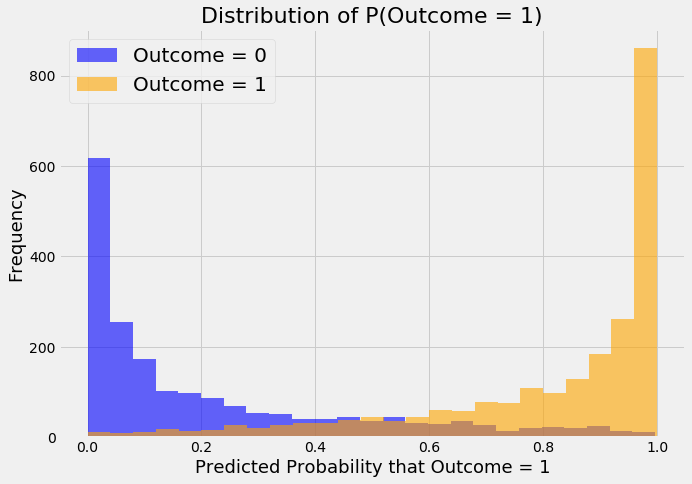

In [1319]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

**We see that the predicted probabilities are well separated, though there is not significant overlap, where the predictions were wrong**

#### Receiver Operating Curve + Area Under Curve

The ROC shows the relationship between sensitivity, calculated as  
**Sensitivity=(True Positives)/(True Positive + False Positives)**

**Specificity=(True Negatives)/(True Negatives + False Positives**

The area under the curve represents how well separated our distributions are, and the closer to 1 it is, the better.

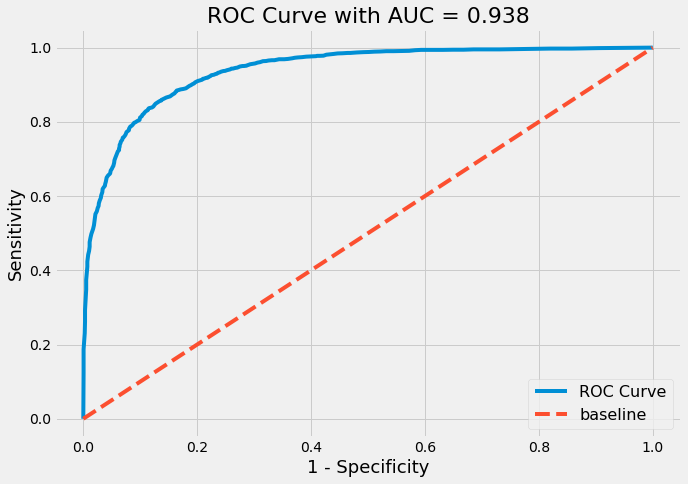

In [1320]:
from sklearn.metrics import roc_auc_score
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

With a AUC of 0.938, our distributions are well-separated

#### Coefficient Analysis

**Exponentiate the coefficients to get the actual probability**

In [1321]:
coefdf=pd.DataFrame(np.exp(lr.coef_[0]),columns=['Coef'])

In [1322]:
coefdf['Feature_Name']=cvec.get_feature_names()

**Top 5 Words/Bi-Grams that indicate that a title is from r/TheOnion**

In [1323]:
coefdf.sort_values('Coef',ascending=False).head()

,Coef,Feature_Name
18025,13.223465,nation
23145,12.589784,said what
17838,5.531259,mueller
28477,5.270616,u .
22186,4.931646,report


**What's 'u .'??**

In [1324]:
dflemma2[['u .' in x for x in dflemma2['titles']]].head(10)

,titles,target
13,u . s . air force retires it vintage nuclear c...,0.0
226,trump warns u . s . ' may have to get in war ',0.0
236,drugstore drone ups will fly cv prescription t...,0.0
376,trump told russian official he wa unconcerned ...,0.0
525,"kim jong un , astride a pale horse , urge self...",0.0
572,u . s . military will stop using floppy disk t...,0.0
688,u . s . troop in syria left behind dick drawin...,0.0
715,most u . s . dairy cow are descended from just...,0.0
727,venezuela win a seat on the u . n . human righ...,0.0
787,the u . s . is running out of a critical child...,0.0


These Coefficients mean that for each occurrence of the word/bigram, the **probability** of the title being from **r/TheOnion** increased by the coefficient amount.  

In the case of the bigram 'u .' which actually is part of 'U.S.' before the pre-processing, each occurrence increases the probability for it to be **r/TheOnion** by **5.42 times** as opposed to a title not containing the same phrase.

**Top 5 Words/Bi-Grams that indicate that a title is from r/nottheonion**

In [1325]:
coefdf.sort_values('Coef',ascending=True).head()

,Coef,Feature_Name
28514,0.173657,ukraine
6541,0.226405,charged
20805,0.228038,police
14268,0.228088,india
16891,0.230645,map


On the other hand, as the negative class, the chance for r/nottheonion is 1/coef. In the case for 'ukraine', the probability of the title being from the subreddit increases by **1/0.173829**, or **5.75** times.

In [1326]:
1/0.173829

5.752780030949956

#### Erroneous Classification Analysis

Where we sample several of the misclassified examples for visual inspection

In [34]:
X=df['titles']
y=df['target']
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=23)
pred_df['titles']=X_test

In [35]:
pred_df['pred']=lr.predict(X_test_cvec)

In [36]:
pred_df.shape

(4274, 4)

In [37]:
misclass=pd.DataFrame(pred_df[pred_df['true_values']!=pred_df['pred']])

In [38]:
misclass.to_csv('misclass.csv')

In [39]:
misclass=pd.read_csv('misclass.csv')

In [52]:
misclass

,Unnamed: 0,true_values,pred_probs,titles,pred
0,1215,0.0,0.765111,Scientists Propose New Satellite Tech to Dodge...,1.0
1,13585,1.0,0.452582,I Was Anti-Vaccine Until My Doctor Got Hot And...,0.0
2,14077,1.0,0.151375,"Excuse Me, Mr. Trump, Sir, But, Respectfully, ...",0.0
3,2470,0.0,0.567020,Priest made young boys dress up like baby Jesu...,1.0
4,4903,0.0,0.535959,Suspected home intruder leaps from 2nd-floor b...,1.0
5,4480,0.0,0.570122,She threw her iPhone out the window and has ne...,1.0
6,10219,1.0,0.322699,Shocking Dark Secret: The Host Of The Beloved ...,0.0
7,3997,0.0,0.512677,Prehistoric Babies Drank Animal Milk From Bottles,1.0
8,11975,1.0,0.203362,We Asked 22 Meteorologists About The Worst Sto...,0.0
9,13909,1.0,0.483765,9/11: Government Admits It Was Only Behind Des...,0.0


In [40]:
import numpy.random as random

In [55]:
random.seed(23)
samples=pd.DataFrame(random.choice(misclass.index,10))

In [60]:
misclass.loc[34,:]

Unnamed: 0                                                  7855
true_values                                                    0
pred_probs                                              0.666589
titles         The most common street name in U.S. is Second....
pred                                                           1
Name: 34, dtype: object

In [75]:
tryclass=[]
for sample in samples[0]:
    print(misclass.loc[sample,'titles'])
    print('Input 1 for the r/TheOnion and 0 for r/nottheonion')
    a=input()
    b=str(misclass.loc[sample,'true_values'].astype(int))

    if a==b:
        print ('Correct!')
        print(f'{a} is equal to {b}')
        tryclass.append(1)
    else:
        print ('You are WRONG')
        print(f'{a} is NOT equal to {b}')
        tryclass.append(0)
        
print(f'\n Your Final Score is: {np.sum(tryclass)}')

All Postpaid Mobile Phones To Be Restored In J&amp;K From Monday
Input 1 for the r/TheOnion and 0 for r/nottheonion
1
You are WRONG
1 is NOT equal to 0
Absolutely No Reason For A Recession But ‘We’ll Probably Have One Anyway’
Input 1 for the r/TheOnion and 0 for r/nottheonion
1
You are WRONG
1 is NOT equal to 0
Savarkar had many faces – but Hindutva has only one
Input 1 for the r/TheOnion and 0 for r/nottheonion
1
You are WRONG
1 is NOT equal to 0
Donald Trump’s New Mideast Point Man Is Jared Kushner’s Personal Assistant
Input 1 for the r/TheOnion and 0 for r/nottheonion
1
You are WRONG
1 is NOT equal to 0
No, RBI is not going to discontinue Rs 2000 currency notes; false message viral
Input 1 for the r/TheOnion and 0 for r/nottheonion

You are WRONG
 is NOT equal to 0
Atheists Will Not Have An Answer For This!
Input 1 for the r/TheOnion and 0 for r/nottheonion

You are WRONG
 is NOT equal to 1
Here Are The Best Moments From Our "Ask Questions At Me" With 'Slip ’N Slide Haircut' Host Cl

Many of these titles are hard to diffrentiate, even by hand, and perhaps it may prove challenging to continue to improve the accuracy score.  

Perhaps these misclassifications are where the real border of the real and surreal are, difficult even for a human observer to differentiate.



## Conclusions

In conclusion, the model used to predict on the data (a Logistic Regression model on a lemmatized dataset) tested an 86% accuracy score against unseen data, and had a ROC AUC of 0.938 on a non-trivial problem, demonstrating both accuracy and well-separated populations.


The proposed model kept a high prediction power, performing only 1.2% worse than the best predictor and considerably shorter runtime as compared to the voting ensemble method. It also maintained a high level of
intepretability, with the ability to predict the effect of the increase in count of individual words in the titles.

The misclassified data was analyzed and was compared to an attempt at hand-classification, which also performed poorly, indicating that the articles in question did appear to the user to be on the difficult end of the scale to predict. Further study on this sub-population of misclassified data would be recommended.